In [2]:
# Import python library for this notebook
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.util import view_as_blocks
from sklearn.linear_model import orthogonal_mp
from PIL import ImageOps, Image
from sparselandtools.learning import ApproximateKSVD
from sparselandtools.dictionaries import Dictionary
from sparselandtools.pursuits import Pursuit, OrthogonalMatchingPursuit

from utils import *


In [61]:
# Langevin wrapper for KSVD library
class lang(Pursuit):
	def fit(self, y):
		sigma=self.tol
		X = self.D
		
		# def omega_bar(t):
		# 	return t ** 2 * (t <= 1) + (2 * np.abs(t) - 1) * (t > 1)

		norm = np.linalg.norm(X, ord='fro')
		beta = 4 * sigma * sigma
		tau = 4 * sigma / norm
		T = X.shape[0]
		h = beta / norm ** 2

		if len(y.shape) == 2:
			L = np.zeros((X.shape[1], y.shape[1]))
		else:
			L = np.zeros(X.shape[1])
		lambd = np.zeros_like(L)
		H = 0
		errs = []

		XX = X.T @ X
		Xy = X.T @ y
		i = 0
		while H < T:
			nablaV = (2 / beta) * (Xy - XX @ L)
			nablaV = nablaV - 4 * L / (tau ** 2 + L ** 2)
			L = L + h * nablaV + np.sqrt(2 * h) * np.random.normal(0, 1, L.shape)
			H = H + 1
			lambd = lambd + h * L / T
		return lambd / h

Mi3_Aligned/Batch_009/


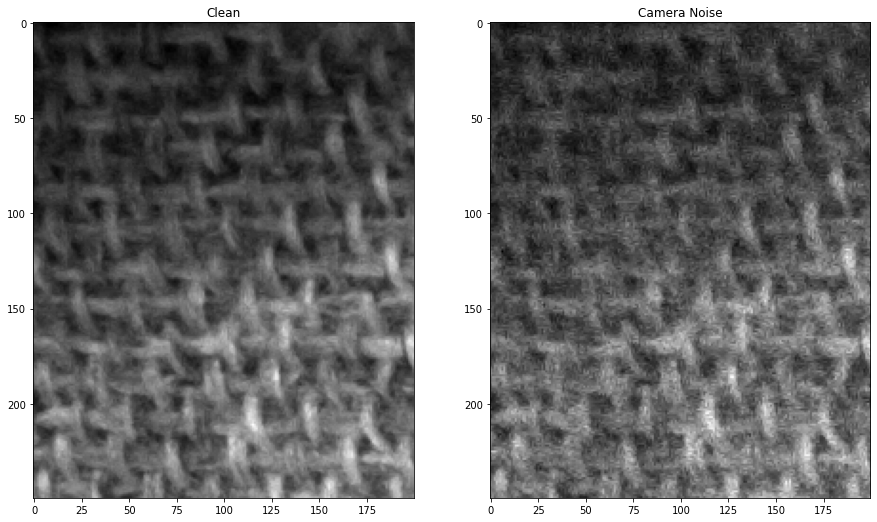

In [63]:
# Retreive image to denoise
batch = os.listdir('Mi3_Aligned')
batch = batch[np.random.randint(0, len(batch))]
batch = 'Batch_009'
imgs = os.listdir('Mi3_Aligned/' + batch)
img_dir = 'Mi3_Aligned/' + batch + '/'
img_ref = [img for img in imgs if img[-6:] == 'ce.bmp'][0]
img_ref = np.array(ImageOps.grayscale(Image.open(img_dir + img_ref)))[350:600, 300:500]
img_noisy = [img for img in imgs if img[-6:] == 'sy.bmp'][0]
img_noisy = np.array(ImageOps.grayscale(Image.open(img_dir + img_noisy)))[350:600, 300:500]

# Patch extraction
shape_patch = (12,12)
stride = (4,4)
img_ref_patches, img_ref_coords = extract_grayscale_patches(img_ref, shape=shape_patch, stride=stride)
img_noisy_patches, img_noisy_coords = extract_grayscale_patches(img_noisy, shape=shape_patch, stride=stride)
print(img_dir)
# Consant for dimensions
n = np.prod(shape_patch)
k = 2 * n
N = len(img_ref_patches)
shape_Y = (n, N)
shape_D = (n, k)
shape_S = (k, N)

# Show image
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title('Clean')
plt.imshow(img_ref, cmap='gray')
plt.subplot(122)
plt.title('Camera Noise')
plt.imshow(img_noisy, cmap='gray')

In [64]:
# Y = D S (columns of Y are noisy patches)
Y = img_noisy_patches.reshape((N, -1)).T
Y = Y / np.linalg.norm(Y, axis=0)
D = np.random.normal(-1, 1, shape_D)
D = D / np.linalg.norm(D, axis=0)
S = np.zeros(shape_S)

ksvd = ApproximateKSVD(
				dictionary=Dictionary(D), 
				pursuit=lang, 
				sparsity=int(n * 0.3),
				noise_gain=1e-1, 
				sigma=1)

ksvd.fit(Y, 80)

D = ksvd.dictionary.matrix
S = ksvd.alphas

INFO:root:Start iteration 1
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 2
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 3
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 4
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 5
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 6
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 7
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 8
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 9
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 10
INFO:roo

<StemContainer object of 3 artists>

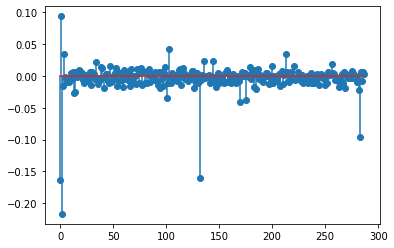

In [65]:
plt.stem(S[:,2])

(2880, 144)


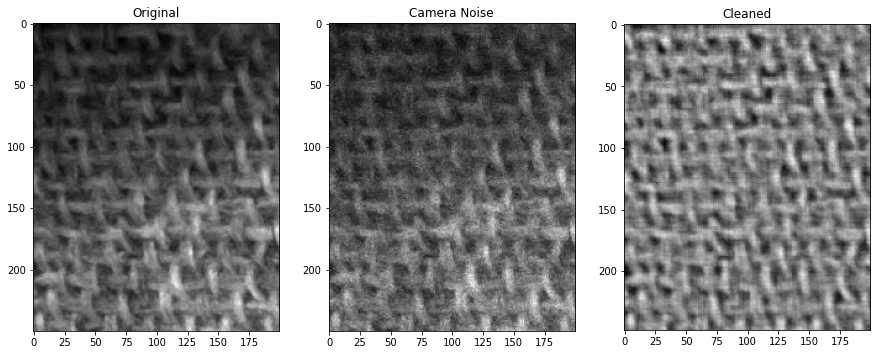

In [66]:
img_recon_matrix = (D @ S).T
print(img_recon_matrix.shape)
img_recon_paches = img_recon_matrix.reshape((-1, shape_patch[0], shape_patch[1]))
img_recon, _ = reconstruct_from_grayscale_patches(img_recon_paches, img_noisy_coords)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Original')
plt.imshow(img_ref, cmap='gray')
plt.subplot(132)
plt.title('Camera Noise')
plt.imshow(img_noisy, cmap='gray')
plt.subplot(133)
plt.title('Cleaned')
plt.imshow(img_recon, cmap='gray')